In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender  # нужен для одного трюка
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k

import missingno as msno

In [29]:
data = pd.read_csv('../data/retail_train.csv')
item_features = pd.read_csv('../data/product.csv')
user_features = pd.read_csv('../data/hh_demographic.csv')

# Анализданных

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2396804 entries, 0 to 2396803
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   user_id            int64  
 1   basket_id          int64  
 2   day                int64  
 3   item_id            int64  
 4   quantity           int64  
 5   sales_value        float64
 6   store_id           int64  
 7   retail_disc        float64
 8   trans_time         int64  
 9   week_no            int64  
 10  coupon_disc        float64
 11  coupon_match_disc  float64
dtypes: float64(4), int64(8)
memory usage: 219.4 MB


In [31]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,2396804.0,1.271904e+03,7.265644e+02,1.000000e+00,6.550000e+02,1.271000e+03,1.914000e+03,2.500000e+03
basket_id,2396804.0,3.336643e+10,4.284798e+09,2.698485e+10,3.008714e+10,3.241998e+10,3.514580e+10,4.165679e+10
day,2396804.0,3.639770e+02,1.759385e+02,1.000000e+00,2.160000e+02,3.660000e+02,5.150000e+02,6.630000e+02
item_id,2396804.0,2.827247e+06,3.732798e+06,2.567100e+04,9.169930e+05,1.027569e+06,1.132178e+06,1.802456e+07
quantity,2396804.0,1.003763e+02,1.152379e+03,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,8.963800e+04
sales_value,2396804.0,3.100821e+00,4.210229e+00,0.000000e+00,1.290000e+00,2.000000e+00,3.490000e+00,8.400000e+02
store_id,2396804.0,3.048227e+03,8.785542e+03,1.000000e+00,3.300000e+02,3.700000e+02,4.220000e+02,3.428000e+04
retail_disc,2396804.0,-5.400708e-01,1.245824e+00,-1.300200e+02,-6.900000e-01,-2.000000e-02,0.000000e+00,3.990000e+00
trans_time,2396804.0,1.561714e+03,4.015691e+02,0.000000e+00,1.307000e+03,1.614000e+03,1.844000e+03,2.359000e+03
week_no,2396804.0,5.268156e+01,2.513310e+01,1.000000e+00,3.200000e+01,5.300000e+01,7.400000e+01,9.500000e+01


In [32]:
item_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92353 entries, 0 to 92352
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   PRODUCT_ID            92353 non-null  int64 
 1   MANUFACTURER          92353 non-null  int64 
 2   DEPARTMENT            92353 non-null  object
 3   BRAND                 92353 non-null  object
 4   COMMODITY_DESC        92353 non-null  object
 5   SUB_COMMODITY_DESC    92353 non-null  object
 6   CURR_SIZE_OF_PRODUCT  92353 non-null  object
dtypes: int64(2), object(5)
memory usage: 4.9+ MB


In [33]:
user_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   AGE_DESC             801 non-null    object
 1   MARITAL_STATUS_CODE  801 non-null    object
 2   INCOME_DESC          801 non-null    object
 3   HOMEOWNER_DESC       801 non-null    object
 4   HH_COMP_DESC         801 non-null    object
 5   HOUSEHOLD_SIZE_DESC  801 non-null    object
 6   KID_CATEGORY_DESC    801 non-null    object
 7   household_key        801 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 50.2+ KB


# Подготовка данных

In [34]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

In [35]:
def prefilter_items(data, take_n_popular=5000, item_features=None):
    # Уберем самые популярные товары (их и так купят)
    popularity = data.groupby('item_id')['user_id'].nunique().reset_index() / data['user_id'].nunique()
    popularity.rename(columns={'user_id': 'share_unique_users'}, inplace=True)

    top_popular = popularity[popularity['share_unique_users'] > 0.2].item_id.tolist()
    data = data[~data['item_id'].isin(top_popular)]

    # Уберем самые НЕ популярные товары (их и так НЕ купят)
    top_notpopular = popularity[popularity['share_unique_users'] < 0.02].item_id.tolist()
    data = data[~data['item_id'].isin(top_notpopular)]

    # Уберем товары, которые не продавались за последние 12 месяцев

    # Уберем не интересные для рекоммендаций категории (department)
    if item_features is not None:
        department_size = pd.DataFrame(item_features.\
                                        groupby('department')['item_id'].nunique().\
                                        sort_values(ascending=False)).reset_index()

        department_size.columns = ['department', 'n_items']
        rare_departments = department_size[department_size['n_items'] < 150].department.tolist()
        items_in_rare_departments = item_features[item_features['department'].isin(rare_departments)].item_id.unique().tolist()

        data = data[~data['item_id'].isin(items_in_rare_departments)]


    # Уберем слишком дешевые товары (на них не заработаем). 1 покупка из рассылок стоит 60 руб.
    data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))
    data = data[data['price'] > 2]

    # Уберем слишком дорогие товарыs
    data = data[data['price'] < 50]

    # Возбмем топ по популярности
    popularity = data.groupby('item_id')['quantity'].sum().reset_index()
    popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

    top = popularity.sort_values('n_sold', ascending=False).head(take_n_popular).item_id.tolist()
    
    # Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
    data.loc[~data['item_id'].isin(top), 'item_id'] = 999999
    
    # ...

    return data

In [36]:
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

# Строим первую модель

In [37]:
class MainRecommender:
    """Рекоммендации, которые можно получить из ALS
    
    Input
    -----
    user_item_matrix: pd.DataFrame
        Матрица взаимодействий user-item
    """
    
    def __init__(self, data, weighting=True):
        
        # your_code. Это не обязательная часть. Но если вам удобно что-либо посчитать тут - можно это сделать
        self.data = data.copy()
        self.popularity = self.data.groupby('item_id')['quantity'].sum().reset_index()
        self.popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)
        self.popularity = self.popularity.sort_values('n_sold', ascending=False).item_id.tolist()		
        
        self.user_item_matrix = self.prepare_matrix(data)  # pd.DataFrame
        self.id_to_itemid, self.id_to_userid,\
            self.itemid_to_id, self.userid_to_id = self.prepare_dicts(self.user_item_matrix)
        
        if weighting:
            self.user_item_matrix = bm25_weight(self.user_item_matrix.T).T 
        
        self.model = self.fit(self.user_item_matrix)
        self.own_recommender = self.fit_own_recommender(self.user_item_matrix)
     
    @staticmethod
    def prepare_data(data, val_lvl_1_size_weeks = 6, val_lvl_2_size_weeks = 3):       
        data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
        data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                              (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

        data_train_lvl_2 = data_val_lvl_1.copy() 
        data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

        return data_train_lvl_1, data_val_lvl_1, data_train_lvl_2, data_val_lvl_2
    
    @staticmethod
    def prepare_matrix(data):
        
        # your_code
        user_item_matrix = pd.pivot_table(data=data, 
                                          index='user_id', columns='item_id', 
                                          values='quantity', # Можно пробовать другие варианты
                                          aggfunc='count', 
                                          fill_value=0)
        
        user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit
        
        return user_item_matrix
    
    @staticmethod
    def prepare_dicts(user_item_matrix):
        """Подготавливает вспомогательные словари"""
        
        userids = user_item_matrix.index.values
        itemids = user_item_matrix.columns.values

        matrix_userids = np.arange(len(userids))
        matrix_itemids = np.arange(len(itemids))

        id_to_itemid = dict(zip(matrix_itemids, itemids))
        id_to_userid = dict(zip(matrix_userids, userids))

        itemid_to_id = dict(zip(itemids, matrix_itemids))
        userid_to_id = dict(zip(userids, matrix_userids))
        
        return id_to_itemid, id_to_userid, itemid_to_id, userid_to_id
     
    @staticmethod
    def fit_own_recommender(user_item_matrix):
        """Обучает модель, которая рекомендует товары, среди товаров, купленных юзером"""
    
        own_recommender = ItemItemRecommender(K=1, num_threads=4)
        own_recommender.fit(csr_matrix(user_item_matrix).T.tocsr())
        
        return own_recommender
    
    @staticmethod
    def fit(user_item_matrix, n_factors=20, regularization=0.001, iterations=15, num_threads=4):
        """Обучает ALS"""
        
        model = AlternatingLeastSquares(factors=n_factors, 
                                             regularization=regularization,
                                             iterations=iterations,  
                                             num_threads=num_threads)
        model.fit(csr_matrix(user_item_matrix).T.tocsr())
        
        return model    

    def get_als_recommendations(self, user, N=5):

        filter_items = [self.itemid_to_id[999999]]
        if user not in self.userid_to_id.keys():
            return self.popularity[:N]

        # your_code
        sparse_user_item=csr_matrix(self.user_item_matrix).tocsr()
        
        res = [self.id_to_itemid[rec[0]] for rec in 
                    self.model.recommend(userid=self.userid_to_id[user], 
                                         user_items=sparse_user_item,   # на вход user-item matrix
                                         N=N, 
                                         filter_already_liked_items=False, 
                                         filter_items=filter_items,
                                         recalculate_user=True)]
        if len(res) < N:
            res = np.append(res, self.popularity[:(N - len(res))])

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res

    def get_own_recommendations(self, user, N=5):
        """Рекомендуем товары среди тех, которые юзер уже купил"""

        if user not in self.userid_to_id.keys():
            return self.popularity[:N]

        filter_items = [self.itemid_to_id[999999]]

        # your_code
        sparse_user_item=csr_matrix(self.user_item_matrix).tocsr()
        
        res = [self.id_to_itemid[rec[0]] for rec in 
                    self.own_recommender.recommend(userid=self.userid_to_id[user], 
                                         user_items=sparse_user_item,   # на вход user-item matrix
                                         N=N, 
                                         filter_already_liked_items=False, 
                                         filter_items=filter_items,
                                         recalculate_user=True)]
 
        if len(res) < N:
            res = np.append(res, self.popularity[:(N - len(res))])

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res
    
recommender = MainRecommender(data_train_lvl_1)

In [38]:
# Готовим тестовый датасет

users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

df=pd.DataFrame({'user_id':users_lvl_2.user_id.values.repeat(len(users_lvl_2.candidates[0])),
                 'item_id':np.concatenate(users_lvl_2.candidates.values)})

targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 
targets_lvl_2 = df.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')
targets_lvl_2['target'].fillna(0, inplace= True)

targets_lvl_2 = df.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

In [39]:
targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,69.0,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,0.0,2468.0,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [40]:
# Средний чек
average_check = data_train_lvl_2.groupby(['user_id', 'basket_id'], as_index=False)['sales_value'].sum()
average_check = average_check.groupby('user_id', as_index=False).mean()
average_check = average_check.drop('basket_id', axis=1)
average_check.rename(columns={'sales_value': 'average_check'}, inplace=True)
targets_lvl_2 = targets_lvl_2.merge(average_check, on='user_id', how='left')
# сумма покупки
num_pur = data_train_lvl_2.merge(item_features, on='item_id', how='left')
num_pur = num_pur.groupby(['user_id', 'department'], as_index=False)['quantity'].sum()
num_pur.rename(columns={'quantity': 'num_pur'}, inplace=True)
num_pur['num_pur'].fillna(0, inplace=True)
targets_lvl_2 = targets_lvl_2.merge(num_pur, on=['user_id', 'department'], how='left')
# Цена
price = data.loc[:,('item_id', 'quantity', 'sales_value')]
price = price.groupby('item_id', as_index=False)[['quantity', 'sales_value']].sum()
price['price'] = price['sales_value'] / price['quantity']
price = price.drop(['quantity', 'sales_value'], axis=1)
targets_lvl_2 = targets_lvl_2.merge(price, on='item_id', how='left')
# Товаров в неделю
goods_per_week = data_train_lvl_2.groupby(['item_id', 'week_no'], as_index=False)['quantity'].sum()
goods_per_week = goods_per_week.groupby('item_id', as_index=False)['quantity'].mean()
goods_per_week.rename(columns={'quantity': 'goods_per_week'}, inplace=True)
goods_per_week['goods_per_week'].fillna(0, inplace=True)
targets_lvl_2 = targets_lvl_2.merge(goods_per_week, on='item_id', how='left')
# Cреднее количество продаж товара
average_number_product  = data_train_lvl_2.groupby(['item_id'])['quantity'].count().reset_index()
average_number_product.rename(columns={'quantity': 'quantity_of_sales'}, inplace=True)
average_number_product['quantity_of_sales_per_week'] = average_number_product['quantity_of_sales'] / data_train_lvl_2['week_no'].nunique()
targets_lvl_2 = targets_lvl_2.merge(average_number_product, on='item_id')

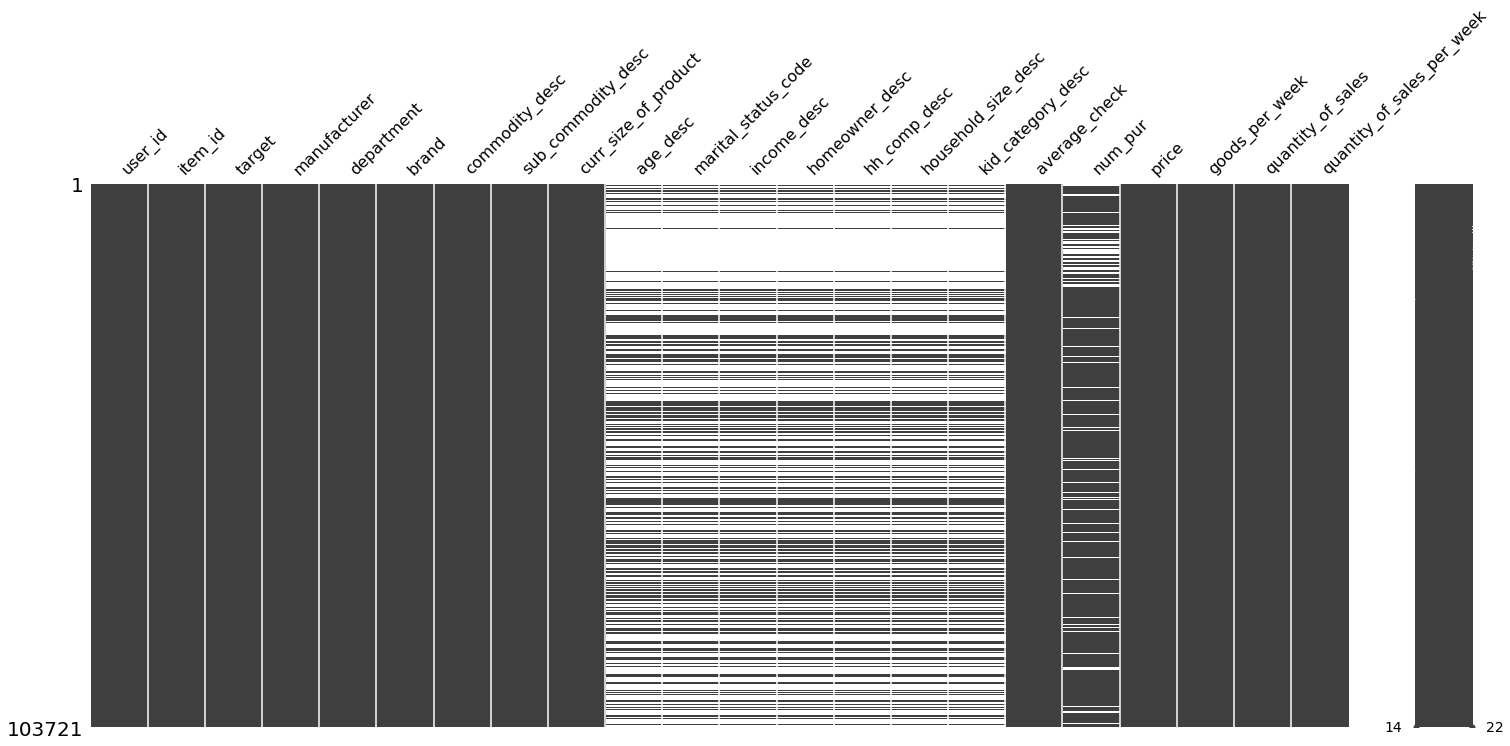

In [41]:
msno.matrix(targets_lvl_2)

In [42]:
# targets_lvl_2.drop(['age_desc', 
#                     "marital_status_code", 
#                     'income_desc', 
#                     'homeowner_desc', 
#                     'hh_comp_desc', 
#                     'household_size_desc',
#                     'kid_category_desc'],
#                    axis=1,
#                    inplace=True)

In [43]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [44]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

In [45]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)
preds = train_preds[:,1]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [46]:
targets_lvl_2['pred'] = preds
targets_lvl_2 = targets_lvl_2.sort_values(['user_id', 'pred'], ascending=[False, False])

In [55]:
result = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [56]:
preds_lgbm = targets_lvl_2[['user_id', 'item_id']].copy().drop_duplicates()
preds_lgbm = preds_lgbm.groupby('user_id')['item_id'].apply(list).reset_index()
preds_lgbm['item_id'] = preds_lgbm.apply(lambda row: row['item_id'][:5], axis=1)

In [57]:
result = result.merge(preds_lgbm, on='user_id', how='left')
result.rename(columns={'item_id': 'lgb'}, inplace=True)

In [58]:
result.head(10)

,user_id,actual,lgb
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[8293439, 9527558, 9297615, 9655212, 856942]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...",NaN
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[900802, 1098844, 12757544, 897088, 878715]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[1122358, 9338009, 1010051, 990897, 983316]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[1088683, 7410201, 6391134, 1095374, 7409951]"
5,9,"[864335, 990865, 1029743, 9297474, 10457112, 8...","[1029743, 862799, 1056509, 8019977, 896085]"
6,13,"[6534178, 1104146, 829197, 840361, 862070, 884...","[1038985, 9859111, 9488065, 886317, 857736]"
7,14,"[840601, 867293, 933067, 951590, 952408, 96569...","[1025611, 1013928, 870843, 857130, 910673]"
8,15,"[910439, 1082185, 959076, 1023958, 1082310, 13...","[13841744, 1026118, 845208, 1082212, 1122358]"
9,16,"[1062973, 1082185, 13007710]","[983584, 1075368, 1029743, 1037840, 1106523]"


In [59]:
#result = result[result['lgb'].notna()]

In [60]:
result['als'] = result['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=5))
result.loc[(result['lgb'].isna()), 'lgb'] = result.loc[(result['lgb'].isna()), 'als']
result.drop('als', axis=1, inplace=True)

In [61]:
result.head(10)

,user_id,actual,lgb
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[8293439, 9527558, 9297615, 9655212, 856942]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1092937, 1008714, 12132312, 1075979, 998206]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[900802, 1098844, 12757544, 897088, 878715]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[1122358, 9338009, 1010051, 990897, 983316]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[1088683, 7410201, 6391134, 1095374, 7409951]"
5,9,"[864335, 990865, 1029743, 9297474, 10457112, 8...","[1029743, 862799, 1056509, 8019977, 896085]"
6,13,"[6534178, 1104146, 829197, 840361, 862070, 884...","[1038985, 9859111, 9488065, 886317, 857736]"
7,14,"[840601, 867293, 933067, 951590, 952408, 96569...","[1025611, 1013928, 870843, 857130, 910673]"
8,15,"[910439, 1082185, 959076, 1023958, 1082310, 13...","[13841744, 1026118, 845208, 1082212, 1122358]"
9,16,"[1062973, 1082185, 13007710]","[983584, 1075368, 1029743, 1037840, 1106523]"


In [62]:
result.apply(lambda row: precision_at_k(row['lgb'], row['actual'], k=5), axis=1).mean()

0.17796278158667805